In [2]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
api = wandb.Api()
# filters = {
#     "config.way": "decomposition",
#     "config.shop_length": {"$in": [2, 3, 4, 5]},
#     "config.data_split_seed": {"$in": [0, 1, 2, 3, 4]},
#     "config.preprocessed_dir": {"$in": ["src/data/complete_graph_preprocessed_separate_enhanced_qnodes_in_snodes"]},
#     "config.use_scheduler": True,
#     "config.scheduler_type": "cosine_restarts",
#     "config.model_architecture": "decoder",
#     "config.is_held_out_color_exp": False,
#     "config.learning_rate": 0.0001,
#     "config.batch_size": 32,
#     "config.epochs": 1000
# }

hop_run_names = {
    2: ['7wd2bh42', 'ixtqit88', 'yvsltr8w'],
    3: ['x163jzlx', '81c9dq9c', '1g9lgsgz'],
    4: ['89woosg5', 'nbls0ig1', 'ay4d6b7x'],
    5: ['axbah548', 'vq7z2tlp', 'xb6q50r9']
}

averaging = False

filtered_runs = [v for k, v in hop_run_names.items() for v in v]
filters = {
    "name": {"$in": filtered_runs},
}

runs = api.runs("simpleparadox/alchemy-meta-learning", filters=filters, per_page=100000)
print(f"Found {len(runs)} runs")


Found 12 runs


In [4]:
# For the runs, get the validation accuracy and epoch for each run
data = []
for run in runs:
    history = run.history(keys=["val_epoch_accuracy", "epoch"], samples=10000)
    # Limit the runs to 500 epochs
    history = history[history["epoch"] <= 500]
    if not history.empty:
        # Only runs with 1000 or less epochs
        # if len(history) > 1000:
        #     history = history.iloc[:1000]
        run_record = {
            "run_name": run.name,
            "val_accuracy": history["val_epoch_accuracy"].tolist(),
            "epoch": history["epoch"].tolist(),
            "shop_length": run.config["shop_length"],
            "qhop_length": run.config["qhop_length"],
            "data_split_seed": run.config["data_split_seed"],
            "run_id": run.id,
        }
        data.append(run_record)

In [5]:
for d in data:
    print(d['epoch'][-1])

500
500
500
500
500
500
500
500
500
500
500
500


In [6]:
df = pd.DataFrame(data)


In [7]:
# df_cleaned = df[df['run_id'] != 'hrc8q58k']
# df = df_cleaned

In [8]:
df.columns

Index(['run_name', 'val_accuracy', 'epoch', 'shop_length', 'qhop_length',
       'data_split_seed', 'run_id'],
      dtype='object')

In [9]:
# print the total len of val_accuracy for each shop_length
for qhop_length in [2, 3, 4, 5]:
    subset = df[df['qhop_length'] == qhop_length]
    lengths = subset['epoch'].apply(len)
    print(f"Shop length {qhop_length}: {lengths.tolist()}")
# Plot the validation accuracy for each shop length

Shop length 2: [500, 500, 500]
Shop length 3: [500, 500, 500]
Shop length 4: [500, 500, 500]
Shop length 5: [500, 500, 500]


In [10]:
# Group the dataframe by shop_length.
grouped = df.groupby("qhop_length")
# For each group, compute the mean and standard deviation of the validation accuracy at each epoch.
summary = {}
for qhop_length, group in grouped:
    max_epochs = max(len(acc) for acc in group["val_accuracy"])
    print(f"Qhop Length {qhop_length} has max epochs {max_epochs}")
    mean_acc = []
    std_acc = []
    sem_acc = []
    for epoch in range(max_epochs):
        epoch_accuracies = [acc[epoch] for acc in group["val_accuracy"] if len(acc) > epoch]
        mean_acc.append(np.mean(epoch_accuracies))
        std_acc.append(np.std(epoch_accuracies))
        sem_acc.append(stats.sem(epoch_accuracies))
    summary[qhop_length] = {
        "mean_accuracy": mean_acc,
        "std_accuracy": std_acc,
        "sem_accuracy": sem_acc,
        "epochs": list(range(max_epochs))
    }

Qhop Length 2 has max epochs 500
Qhop Length 3 has max epochs 500
Qhop Length 4 has max epochs 500
Qhop Length 5 has max epochs 500


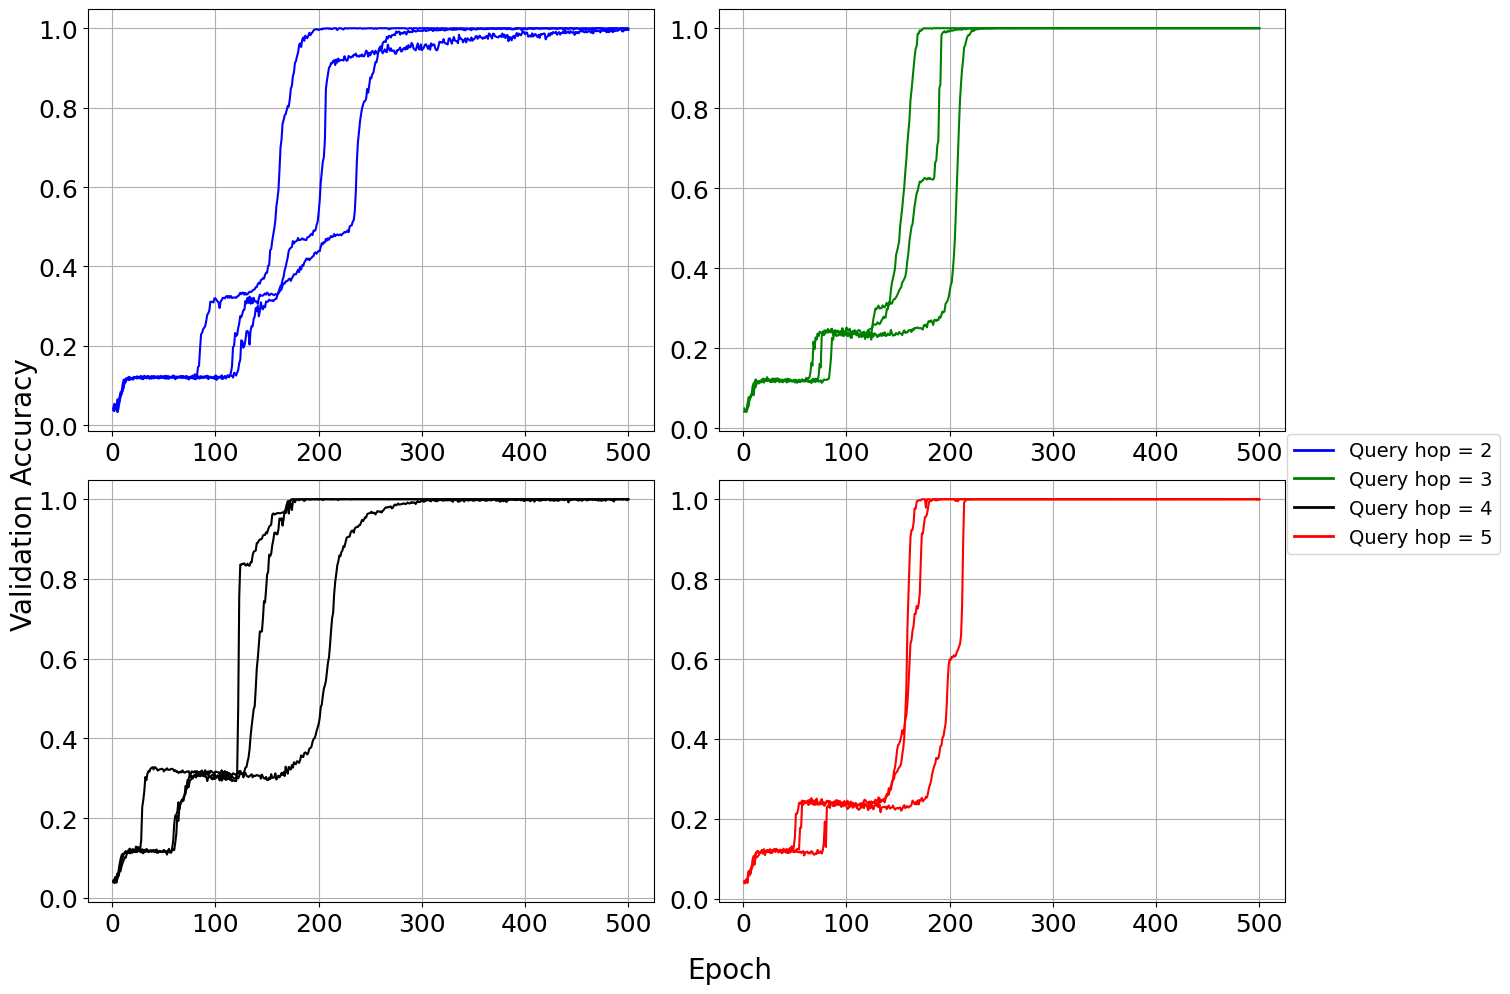

In [11]:
# Alternative is to plot the individual runs with lighter lines, and the mean with a thicker line.
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
colors = {2: 'blue', 3: 'green', 4: 'black', 5: 'red'}
for idx, (qhop_length, stats) in enumerate(summary.items()):
    epochs = stats['epochs']
    mean_acc = stats['mean_accuracy']

    # Plot individual runs
    runs_for_hop = df[df['qhop_length'] == qhop_length]
    for _, run in runs_for_hop.iterrows():
        ax[idx // 2, idx % 2].plot(run['epoch'], run['val_accuracy'], color=colors[qhop_length], alpha=1.0)
    # Plot mean accuracy
    # ax[idx // 2, idx % 2].plot(epochs, mean_acc, color=colors[qhop_length], label=f'Qhop Length {qhop_length}', linewidth=2)
    # ax[idx // 2, idx % 2].fill_between(epochs, np.array(mean_acc) - np.array(stats['sem_accuracy']), np.array(mean_acc) + np.array(stats['sem_accuracy']), color=colors[qhop_length], alpha=0.2)
    # Subplot styling (no per-axes legends)
    ax[idx // 2, idx % 2].grid(True)
    ax[idx // 2, idx % 2].tick_params(axis='both', labelsize=18)

# Figure-level labels and legend (set once)
fig.supxlabel('Epoch', fontsize=20)
fig.supylabel('Validation Accuracy', fontsize=20)

# Build a single legend for the whole figure (one entry per qhop_length)
handles = [plt.Line2D([0], [0], color=colors[q], lw=2) for q in summary.keys()]
labels = [f'Query hop = {q}' for q in summary.keys()]
fig.legend(handles, labels, fontsize=14, loc='center right', bbox_to_anchor=(1.02, 0.5))

# Leave room on the right for the figure legend
fig.tight_layout(rect=[0, 0, 0.88, 1])
# plt.show()

plt.savefig("val_accuracy_by_qhop_length_individual_runs.png", bbox_inches='tight')
plt.savefig("val_accuracy_by_qhop_length_individual_runs.pdf", bbox_inches='tight')

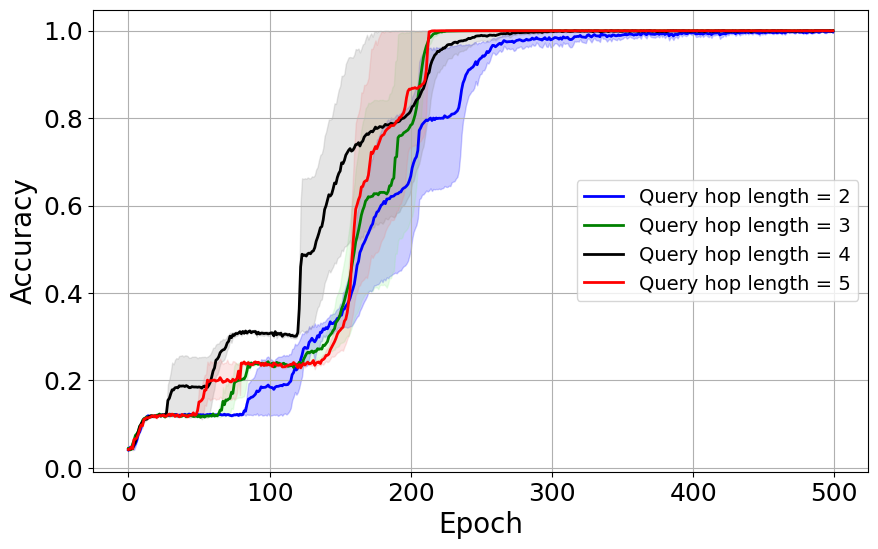

In [12]:
# Plot the mean and standard deviation of the validation accuracy for each shop_length.
plt.figure(figsize=(10, 6))
colors = {2: 'blue', 3: 'green', 4: 'black', 5: 'red'}
sem_colors = {2: 'blue', 3: 'lightgreen', 4: 'gray', 5: 'lightcoral'}
annotation_epochs = [0, 50, 100, 200, 400, 600, 800, 999]
for qhop_length, st in summary.items():
    mean_acc = st["mean_accuracy"]
    std_acc = st["std_accuracy"]
    epochs = st["epochs"]
    plt.plot(epochs, mean_acc, label=f"Query hop length = {qhop_length}", color=colors[qhop_length], linewidth=2)
    # plt.fill_between(epochs, np.array(mean_acc) - np.array(std_acc), np.array(mean_acc) + np.array(std_acc), alpha=0.2)
    plt.fill_between(epochs, np.array(mean_acc) - np.array(st["sem_accuracy"]), np.array(mean_acc) + np.array(st["sem_accuracy"]), alpha=0.2, color=sem_colors[qhop_length])
    # Annotate specific epochs with the accuracy value to two decimal places


    # if shop_length == 2:
    #     annotation_epochs = [0, 50, 100, 200, 400, 600, 800, 999]
    # else:
    annotation_epochs = [400, 600, 800, 999]

    # for epoch in annotation_epochs:
    #     if epoch < len(mean_acc):
    #         accuracy = mean_acc[epoch]
    #         acc_percent = accuracy * 100
    #         # plt.text(epoch, accuracy, f'{acc_percent:.2f}', fontsize=12, ha='center', va='bottom', rotation=45, color=colors[shop_length])
    #         plt.text(epoch, accuracy + 0.1, f'{acc_percent:.2f}', fontsize=12, ha='center', va='bottom', rotation=45, color=colors[qhop_length])


plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
# plt.title("Validation Accuracy by Task Complexity (Support hop length)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14, loc='center right')
plt.grid()
# plt.show()

# Save the plot as a pdf and remove any extra whitespace.
# plt.savefig("composition_plot_all_hops_500_epochs_updated_2_hop.png", bbox_inches='tight', dpi=300)  
# plt.savefig("composition_plot_all_hops_500_epochs_updated_2_hop.pdf", bbox_inches='tight')

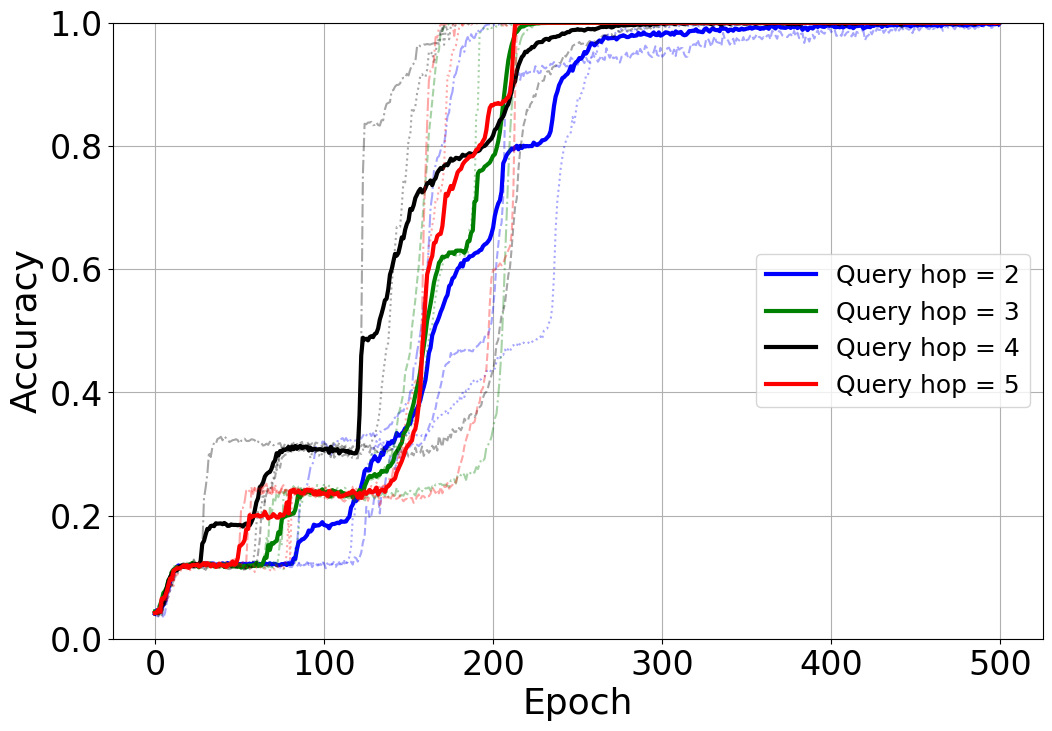

In [21]:

# Combined plot: individual runs (light) + mean (dark) on one figure
fig, ax = plt.subplots(figsize=(12, 8))
colors = {2: 'blue', 3: 'green', 4: 'black', 5: 'red'}

light_alpha = 0.35   # lighter shade for individual runs
mean_alpha = 1.0     # darker/opaque for mean
run_lw = 1.5
mean_lw = 3.0

for qhop_length in sorted(summary.keys()):
    base_color = colors[qhop_length]

    # Plot individual runs for this hop
    runs_for_hop = df[df['qhop_length'] == qhop_length]
    # linestyles for individual runs
    linestyles = ['--', '-.', ':']
    for _, run in runs_for_hop.iterrows():
        ax.plot(
            run['epoch'],
            run['val_accuracy'],
            color=base_color,
            alpha=light_alpha,
            linewidth=run_lw,
            linestyle=linestyles[_ % len(linestyles)]
        )

    # Plot mean curve for this hop
    st = summary[qhop_length]
    ax.plot(
        st['epochs'],
        st['mean_accuracy'],
        color=base_color,
        alpha=mean_alpha,
        linewidth=mean_lw,
        label=f'Query hop = {qhop_length}'
    )

# Styling
ax.set_xlabel('Epoch', fontsize=26)
ax.set_ylabel('Accuracy', fontsize=26)
ax.grid(True)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', labelsize=24)
ax.legend(fontsize=18, loc='center right')

plt.savefig("composition_all_hops_val_accuracy_individual_and_mean_one_figure.png", bbox_inches='tight', dpi=300)
plt.savefig("composition_all_hops_val_accuracy_individual_and_mean_one_figure.pdf", bbox_inches='tight', dpi=300)